In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [2]:
import scienceplots

In [3]:
# ANADIR='../selected/'
ANADIR='../PROD/'

In [4]:
!pwd

/public1/home/a8s000527/kluo/liq-vap-production/production/4000/analysis


In [5]:
Lomonosov_vap = np.loadtxt("vapor_line_Lomonosov2007.txt", delimiter=',')
Lomonosov_liq = np.loadtxt("liquid_line_Lomonosov2007.txt", delimiter=',')
# Lomonosov_vap, Lomonosov_liq

In [6]:
# data = np.loadtxt(os.path.join(ANADIR, "0.6-4000", "density.dat"))
# data

In [7]:
files = np.sort(glob.glob(os.path.join(ANADIR, "*", "density_filter.dat"), recursive=True))
files = files[:-3]
# files = files[:-2]
files

array(['../PROD/0.6-3500/density_filter.dat',
       '../PROD/0.6-3750/density_filter.dat',
       '../PROD/0.6-4000/density_filter.dat',
       '../PROD/0.6-4250/density_filter.dat',
       '../PROD/0.6-4500/density_filter.dat',
       '../PROD/0.6-4750/density_filter.dat',
       '../PROD/0.6-5000/density_filter.dat',
       '../PROD/0.6-5250/density_filter.dat'], dtype='<U35')

In [8]:
result= []
for file in files:
    temp = file.split('/')[2].split('-')[1]
    # print(temp)
    data = list(np.loadtxt(file))
    line = [temp] + [ i for i in data]
    result.append(line)
final= np.array(result, dtype=np.float32)
np.savetxt("coexistence.dat", final)

## use rectilinear diameter

In [9]:
plt.style.use(['science', 'nature','vibrant', "notebook" ])


In [10]:
T = final[:,0]
rho_l = final[:,1]
rho_l_err = final[:, 2]
rho_v = final[:, 3]
rho_v_err = final[:, 4]

In [11]:
# Prepare data
delta_rho = rho_l - rho_v
avg_rho = 0.5 * (rho_l + rho_v)

In [12]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# === Your input data ===
T = final[:,0]
rho_l = final[:,1]
err_l = final[:, 2]
rho_v = final[:, 3]
err_v = final[:, 4]


# === Fixed critical exponent ===
beta_fixed = 0.326

# Coexistence scaling law with fixed beta
def scaling_law_fixed_beta(T, Tc, A):
    return A * (Tc - T)**beta_fixed

# Rectilinear diameter law (uses Tc from first fit)
def rectilinear_diameter(T, Tc, rhoc, B):
    return rhoc + B * (Tc - T)

In [13]:
from numpy import sqrt, diag

# === Prepare data ===
delta_rho = rho_l - rho_v
avg_rho = 0.5 * (rho_l + rho_v)
delta_rho_err = np.sqrt(err_l**2 + err_v**2)
avg_rho_err = 0.5 * np.sqrt(err_l**2 + err_v**2)

# Fit scaling law
popt_diff, pcov_diff = curve_fit(scaling_law_fixed_beta, T, delta_rho, p0=[max(T) + 1, 1.0])
Tc_fit, A_fit = popt_diff

# Fit rectilinear diameter with Tc fixed
popt_avg, pcov_avg = curve_fit(lambda T, rhoc, B: rectilinear_diameter(T, Tc_fit, rhoc, B), T, avg_rho, p0=[avg_rho[-1], 1.0])
rhoc_fit, B_fit = popt_avg

# Uncertainties from fit covariance matrices
Tc_err = sqrt(pcov_diff[0, 0])      # error in Tc
A_err = sqrt(pcov_diff[1, 1])       # error in A

rhoc_err = sqrt(pcov_avg[0, 0])     # error in rhoc
B_err = sqrt(pcov_avg[1, 1])        # error in B

print(f"Tc     = {Tc_fit:.6f} ± {Tc_err:.6f}")
print(f"A      = {A_fit:.6f} ± {A_err:.6f}")
print(f"rho_c  = {rhoc_fit:.6f} ± {rhoc_err:.6f}")
print(f"B      = {B_fit:.6f} ± {B_err:.6f}")


Tc     = 6559.862365 ± 48.321588
A      = 0.126086 ± 0.000969
rho_c  = 0.596788 ± 0.006995
B      = 0.000088 ± 0.000003


# === Plotting ===

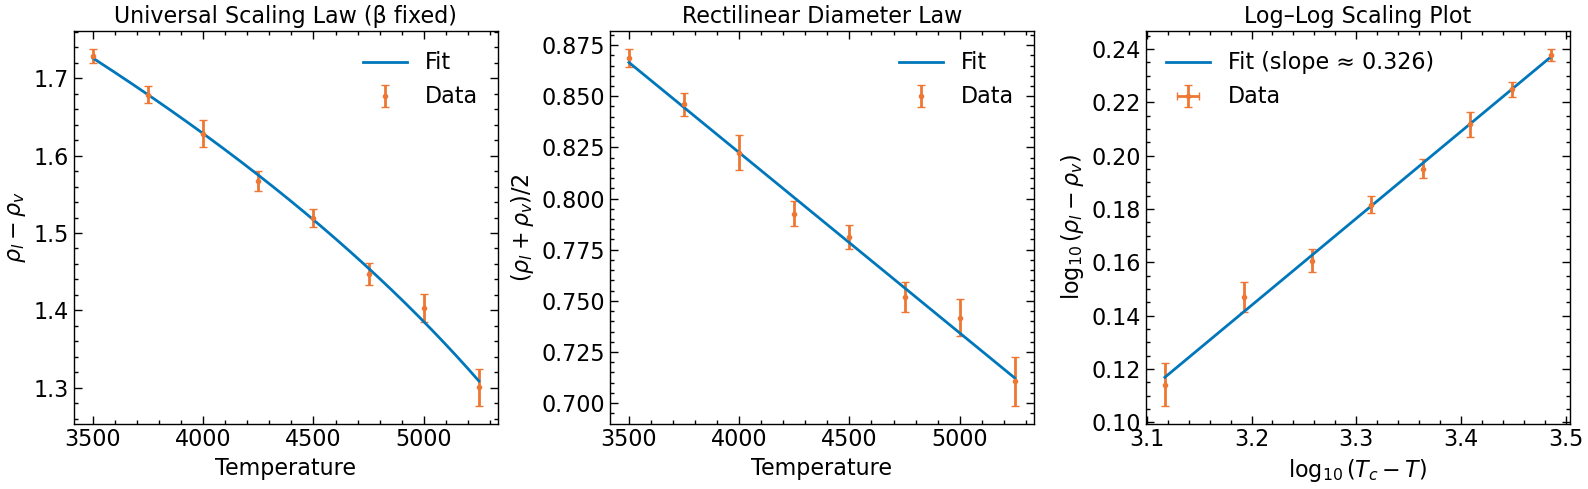

In [14]:
T_plot = np.linspace(min(T), max(T), 200)

fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# --- Plot 1: Scaling law (linear) ---
axs[0].errorbar(T, delta_rho, yerr=delta_rho_err, fmt='o', label='Data', capsize=3)
axs[0].plot(T_plot, scaling_law_fixed_beta(T_plot, *popt_diff), '-', label='Fit')
axs[0].set_xlabel('Temperature')
axs[0].set_ylabel(r'$\rho_l - \rho_v$')
axs[0].set_title('Universal Scaling Law (β fixed)')
axs[0].legend()

# --- Plot 2: Rectilinear diameter (linear) ---
axs[1].errorbar(T, avg_rho, yerr=avg_rho_err, fmt='o', label='Data', capsize=3)
axs[1].plot(T_plot, rectilinear_diameter(T_plot, Tc_fit, *popt_avg), '-', label='Fit')
axs[1].set_xlabel('Temperature')
axs[1].set_ylabel(r'$(\rho_l + \rho_v)/2$')
axs[1].set_title('Rectilinear Diameter Law')
axs[1].legend()

# --- Plot 3: Scaling law (log-log plot) ---
axs[2].errorbar(
    np.log10(Tc_fit - T), np.log10(delta_rho),
    xerr=0, yerr=delta_rho_err / (delta_rho * np.log(10)),  # error in log(y)
    fmt='o', capsize=3, label='Data'
)
axs[2].plot(
    np.log10(Tc_fit - T_plot),
    np.log10(scaling_law_fixed_beta(T_plot, *popt_diff)),
    label=f'Fit (slope ≈ {beta_fixed})'
)
axs[2].set_xlabel(r'$\log_{10}(T_c - T)$')
axs[2].set_ylabel(r'$\log_{10}(\rho_l - \rho_v)$')
axs[2].set_title('Log–Log Scaling Plot')
axs[2].legend()

plt.tight_layout()
plt.savefig("law_fit.png", dpi=300)
plt.show()

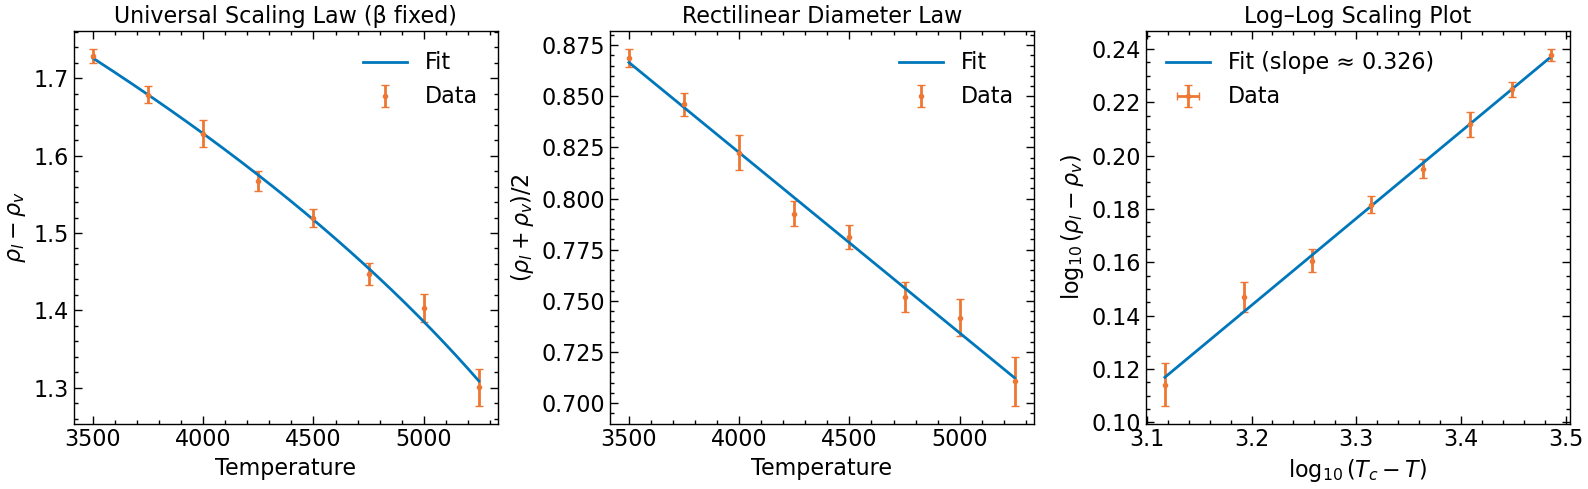

In [28]:
with plt.style.context(['science', 'nature','vibrant', "notebook"]):
    T_plot = np.linspace(min(T), max(T), 200)
    
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    
    # --- Plot 1: Scaling law (linear) ---
    axs[0].errorbar(T, delta_rho, yerr=delta_rho_err, fmt='o', label='Data', capsize=3)
    axs[0].plot(T_plot, scaling_law_fixed_beta(T_plot, *popt_diff), '-', label='Fit')
    axs[0].set_xlabel('Temperature')
    axs[0].set_ylabel(r'$\rho_l - \rho_v$')
    axs[0].set_title('Universal Scaling Law (β fixed)')
    axs[0].legend()
    
    # --- Plot 2: Rectilinear diameter (linear) ---
    axs[1].errorbar(T, avg_rho, yerr=avg_rho_err, fmt='o', label='Data', capsize=3)
    axs[1].plot(T_plot, rectilinear_diameter(T_plot, Tc_fit, *popt_avg), '-', label='Fit')
    axs[1].set_xlabel('Temperature')
    axs[1].set_ylabel(r'$(\rho_l + \rho_v)/2$')
    axs[1].set_title('Rectilinear Diameter Law')
    axs[1].legend()
    
    # --- Plot 3: Scaling law (log-log plot) ---
    axs[2].errorbar(
        np.log10(Tc_fit - T), np.log10(delta_rho),
        xerr=0, yerr=delta_rho_err / (delta_rho * np.log(10)),  # error in log(y)
        fmt='o', capsize=3, label='Data'
    )
    axs[2].plot(
        np.log10(Tc_fit - T_plot),
        np.log10(scaling_law_fixed_beta(T_plot, *popt_diff)),
        label=f'Fit (slope ≈ {beta_fixed})'
    )
    axs[2].set_xlabel(r'$\log_{10}(T_c - T)$')
    axs[2].set_ylabel(r'$\log_{10}(\rho_l - \rho_v)$')
    axs[2].set_title('Log–Log Scaling Plot')
    axs[2].legend()
    
    plt.tight_layout()
    plt.savefig("law_fit_pub.png", dpi=300)
    plt.show()

In [15]:
# === Evaluate fitted density curves ===
def rho_l_fit(T):
    delta_rho = scaling_law_fixed_beta(T, Tc_fit, A_fit)
    rho_avg = rectilinear_diameter(T, Tc_fit, rhoc_fit, B_fit)
    return rho_avg + 0.5 * delta_rho

def rho_v_fit(T):
    delta_rho = scaling_law_fixed_beta(T, Tc_fit, A_fit)
    rho_avg = rectilinear_diameter(T, Tc_fit, rhoc_fit, B_fit)
    return rho_avg - 0.5 * delta_rho

finer_T = np.linspace(3250, Tc_fit, 200)
# finer_T = np.logspace(np.log(3500), np.log(Tc_fit), 100)
# === Example: compute fitted rho_l and rho_v on original T points ===
rho_l_fitted = rho_l_fit(finer_T)
rho_v_fitted = rho_v_fit(finer_T)

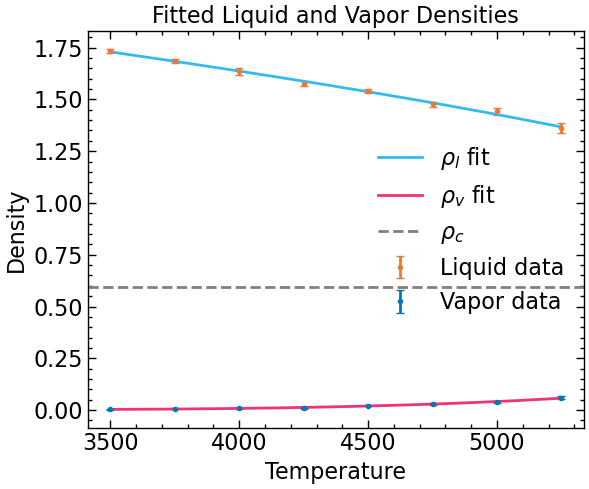

In [16]:
# === rho_c directly from fit ===
# print(f"Critical density (rho_c) = {rhoc_fit:.6f}")

# Optional: plot fitted rho_l and rho_v
plt.figure(figsize=(6, 5))
plt.errorbar(T, rho_l, yerr=err_l, fmt='o', label='Liquid data', capsize=3)
plt.errorbar(T, rho_v, yerr=err_v, fmt='o', label='Vapor data', capsize=3)
plt.plot(T_plot, rho_l_fit(T_plot), '-', label=r'$\rho_l$ fit')
plt.plot(T_plot, rho_v_fit(T_plot), '-', label=r'$\rho_v$ fit')
plt.axhline(rhoc_fit, ls='--', color='gray', label=r'$\rho_c$')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.title('Fitted Liquid and Vapor Densities')
plt.legend()
plt.tight_layout()
plt.show()

## Load existing data

# Export a clean curve of coexistance 

In [17]:
T_ex = np.linspace(3500, Tc_fit, 15)
T_list = [ round(float(T)-1,1) for T in T_ex]
T_list

[3499.0,
 3717.6,
 3936.1,
 4154.7,
 4373.2,
 4591.8,
 4810.4,
 5028.9,
 5247.5,
 5466.1,
 5684.6,
 5903.2,
 6121.7,
 6340.3,
 6558.9]

In [18]:
def write_coexdata():
    f = open("coex_smooth.dat", "w")
    for temp in T_list:
        rho_l = rho_l_fit(temp)
        rho_v = rho_v_fit(temp)
        f.write("%.1f %.6f %.6f\n" %(temp, rho_l, rho_v))
    f.close()
write_coexdata()

# Plot

In [19]:
import pandas as pd

In [20]:
df=pd.read_csv("critical.csv")
df[df['Author'] == 'Young']

,Author,year,rhoc,Tc,Pc,Zc
0,Young,1971,0.69,7151,0.5458,0.36


## 

In [21]:
Young=df[df['Author'] == 'Young']['Tc']
Young

0    7151
Name: Tc, dtype: int64

In [22]:
density_data = pd.read_csv("/public1/home/a8s000527/kluo/liq-vap-production/density/density_datasets.csv", header=[0,1], na_filter=True)
# density_data_clean =  density_data.dropna(how='all')
density_data.columns = ["Smithells X", "Smithells Y", "Schmitz X", "Schmitz Y", "Leitner X", "Leitner Y", "Leinter2 X", "Leinter2 Y",
                        "Tokolian X", "Tokolian Y"]
density_data

,Smithells X,Smithells Y,Schmitz X,Schmitz Y,Leitner X,Leitner Y,Leinter2 X,Leinter2 Y,Tokolian X,Tokolian Y
0,1732.055605,2160.640019,1548.907902,2174.907023,968.637514,2380.083716,901.435066,2314.524746,1599.655312,2245.684476
1,1632.029562,2188.278398,1499.625990,2190.087405,995.741976,2372.038141,928.539959,2306.904245,1499.134179,2264.833976
2,1632.029562,2188.278398,1449.613808,2204.734144,1022.846316,2363.871115,955.644893,2299.324226,1399.504452,2283.502647
3,1532.814277,2215.863099,1399.602654,2220.395297,1049.950758,2355.805298,982.749848,2291.764450,1299.875373,2302.812000
4,1432.789587,2244.836234,1349.509444,2235.095455,1077.055076,2347.618031,1009.854721,2284.123707,1199.759592,2321.907966
5,1332.844626,2272.474585,1299.659857,2250.169258,1103.004669,2339.873295,1036.959675,2276.563930,1100.454730,2341.110424
6,1233.548746,2300.539826,1249.648216,2265.349899,1131.263837,2331.364947,1064.064528,2268.902945,999.852517,2360.259953
7,1133.442435,2328.979088,1199.717115,2279.996609,1158.368258,2323.278888,1091.169441,2261.302685,930.952453,2378.864295
8,1033.497474,2356.617438,1149.786554,2295.177221,1185.472638,2315.152346,1117.667039,2253.949113,NaN,NaN
9,932.904784,2385.163654,1099.693832,2310.357892,1212.576978,2306.985321,1145.379207,2246.041441,NaN,NaN


In [23]:
gathers_data = pd.read_csv("/public1/home/a8s000527/kluo/liq-vap-production/density/Gathers.csv")
gathers_data

,Temperature_K,v_over_v0,Density_kg_per_m3
0,933,1.116,2417.855768
1,1000,1.123,2402.784539
2,1500,1.180,2286.717828
3,2000,1.240,2176.070191
4,2500,1.300,2075.636182
5,3000,1.370,1969.581779
6,3500,1.440,1873.838220
7,4000,1.520,1775.215156
8,5000,1.560,1729.696819
9,5500,1.630,1655.415360


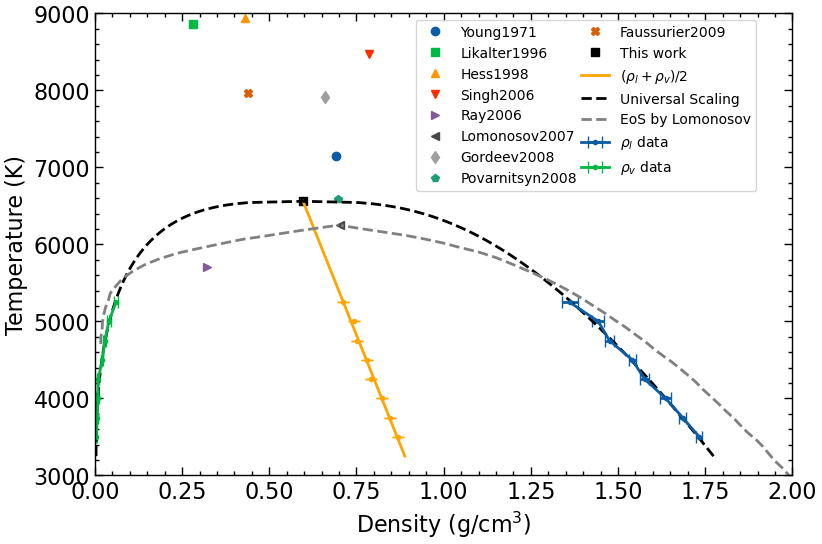

In [24]:
# plt.style.use(['science', 'nature','vibrant', "notebook"])


plt.figure(figsize=(9, 6))
# plt.errorbar(final[:,0], final[:, 1], yerr=final[:,2], fmt='o-', label="liquid")
# plt.errorbar(final[:,0], final[:, 3], yerr=final[:,4], fmt='o-', label="vapor")
# plt.style.use(['science', 'nature','vibrant', "notebook", "scatter" ])
# 

with plt.style.context(['science', 'nature','vibrant', "notebook", "scatter"]):
# with plt.style.context([ "scatter"]):
    plt.xlim((0, 2.0))
    plt.ylim((3000, 9000))
    plt.xlabel("Density (g/cm$^3$)")
    plt.ylabel("Temperature (K)")
    # plt.title("Aluminum liquid-vapor coexistence")

    
    # plt.style.use(['science', 'nature','vibrant', "notebook"])
    # plt.style.use(['science', 'vibrant', "notebook", "scatter" ])
    # plt.style.use(['science', 'vibrant',  "scatter" ])
    # print(rcParams['axes.prop_cycle'])
    # rcParams['axes.prop_cycle'] = cycler(marker= ['o', 's', '^', 'v', '<', '>', 'd', '*', 'p' ], )
    # color= ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e', '#1b9e77', '#d95f02']) 
    # Extended Nature-style color palette
    colors = [
        "#0C5DA5", "#00B945", "#FF9500", "#FF2C00",
        "#845B97", "#474747", "#9e9e9e",
        "#1b9e77", "#d95f02", "#7570b3", "#e7298a",
        "#66a61e", "#e6ab02", "#a6761d", "#666666",
    ]
    
    # # A list of distinct markers (15 to match color count)
    markers = ['o', 's', '^','v', '>', '<', 'd', 'p',  'X',  'H', '8', 'p', '*', '.', 'x']
    
    # # # Combine into a custom prop_cycle
    # plt.rcParams['axes.prop_cycle'] = cycler(color=colors, marker=markers)
    plt.errorbar(rho_l, T, xerr=err_l, fmt='o-', linestyle=None, capsize=4, label=r"$\rho_l$ data")
    plt.errorbar(rho_v, T, xerr=err_v, fmt='o-',  linestyle=None,  capsize=4, label=r"$\rho_v$ data")
    
    # Existing data
    for index, row in df.iterrows():
        # print(row['year'])
        plt.plot(row['rhoc'], row['Tc'], markersize=6, marker = markers[index], color=colors[index], label=row['Author']+ str(row['year']))
        # plt.scatter(row['rhoc'], row['Tc'], label=row['Author']+ str(row['year']))
        # plt.scatter(row['rhoc'], row['Tc'], s=25, label=row['Author'])
    
    # plt.axvline(rhoc_fit, ls='--', color='gray', label=r'$\rho_c$')
    plt.plot(rhoc_fit, Tc_fit, marker= 's', markersize=6, color='black', label='This work')


    


    
    # --- Plot 2: Rectilinear diameter (linear) ---
    # plt.plot( rectilinear_diameter(finer_T, Tc_fit, *popt_avg), finer_T, '-', color='grey', label=r'$(\rho_l + \rho_v)/2$')
    plt.errorbar(avg_rho,T, yerr=avg_rho_err,  fmt='o', label='_Data',color='orange', capsize=4)
    plt.plot( rectilinear_diameter(finer_T, Tc_fit, *popt_avg), finer_T, '-', color='orange', label=r'$(\rho_l + \rho_v)/2$')

    # plt.plot(rho_avg, T , linestyle="--", marker='s', label = "_diameter")
    # plt.errorbar(final[:,1], final[:, 0], fmt='o-', capsize=3, label="liquid")
    # plt.errorbar(final[:,3], final[:, 0], fmt='o-', capsize=3, label="vapor")
    # plt.xscale("log")



    plt.plot( rho_l_fit(finer_T),finer_T, color = 'black',linewidth=2, linestyle='--', marker='', label=r'Universal Scaling')
    # plt.plot( rho_v_fit(finer_T), finer_T,'--', label=r'$\rho_v$ fit')
    plt.plot( rho_v_fit(finer_T), finer_T, color ='black',linewidth=2, linestyle='--', marker='')

    plt.plot( Lomonosov_liq[:,1],Lomonosov_liq[:,0], color = 'grey', linewidth=2, linestyle='--', marker='', label=r'EoS by Lomonosov')
    # plt.plot( rho_v_fit(finer_T), finer_T,'--', label=r'$\rho_v$ fit')
    plt.plot( Lomonosov_vap[:,1],Lomonosov_vap[:,0], color ='grey', linewidth=2, linestyle='--', marker='')


    # plt.plot( gathers_data["Density_kg_per_m3"]/1000, gathers_data["Temperature_K"], label = "Gathers")

    # plt.plot( density_data["Smithells Y"]/1000, density_data["Smithells X"], label = "Smithells")
    # plt.plot( density_data["Schmitz Y"]/1000, density_data["Schmitz X"], label = "Schmitz")
    # plt.plot( density_data["Leitner Y"]/1000, density_data["Leitner X"], label = "Leitner")
    # plt.plot( density_data["Leinter2 Y"]/1000, density_data["Leinter2 X"], label = "Leitner2")
    # plt.plot( density_data["Tokolian Y"]/1000, density_data["Tokolian X"], label = "Tokolian")

    
    # plt.legend(frameon=False, fontsize=10, loc=4, ncol=3)
    plt.legend(frameon=True, fontsize=10, ncol=2, bbox_to_anchor = (0.45, 0.60), columnspacing=0.3 )

    plt.savefig("coex.jpg", dpi=300)
    plt.savefig("coex.png", dpi=600)
    plt.show()
    plt.close()

In [25]:
!pwd

/public1/home/a8s000527/kluo/liq-vap-production/production/4000/analysis
